In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["SERPAPI_API_KEY"] = os.getenv("SERPAPI_API_KEY")
os.environ["ALPHA_VANTAGE_API_KEY"] = os.getenv("ALPHA_VANTAGE_API_KEY")
alphavantage_api_key = os.getenv("ALPHA_VANTAGE_API_KEY")

In [ ]:
from typing_extensions import TypedDict
from typing import Annotated

from langchain.chat_models import init_chat_model
from langchain_community.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage
from langchain_community.tools.google_finance import GoogleFinanceQueryRun
from langchain_community.utilities.google_finance import GoogleFinanceAPIWrapper
from langchain_community.utilities.alpha_vantage import AlphaVantageAPIWrapper
from langchain_experimental.tools.python.tool import PythonREPLTool 

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

In [3]:
# LLM
llm = init_chat_model("openai:gpt-4.1", temperature = 0.7)
print("LLM:", llm.invoke("Hello, My name is Viswa"))



# Google Finance Tool
google_finance_tool = GoogleFinanceQueryRun(api_wrapper=GoogleFinanceAPIWrapper())
print(google_finance_tool.invoke("google"))



# Alpha Vantage Tool
alpha_vantage_tool = AlphaVantageAPIWrapper(alphavantage_api_key = alphavantage_api_key)
@tool
def get_alpha_vantage_tool(from_currency: str, to_currency: str) -> str:
    """ 
    Retrieves the currency exchange rate between two specified currencies
    """
    return alpha_vantage_tool.run(from_currency=from_currency, to_currency=to_currency)

print(alpha_vantage_tool.run("INR", "USD"))




#Python REPL
repl_tool = PythonREPLTool()
output = repl_tool.run("print(1 + 2)")
print("Output:", output)


LLM: content='Hello Viswa! Nice to meet you. How can I help you today? 😊' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 14, 'total_tokens': 31, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_799e4ca3f1', 'id': 'chatcmpl-BxF13gNffyEdcsB7WrjNhQDmdjH6A', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--0c2aa919-246f-495d-b467-34800b741263-0' usage_metadata={'input_tokens': 14, 'output_tokens': 17, 'total_tokens': 31, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}

Query: google
stock: GOOGL:NASDAQ
price: $193.43
percentage: 0.66
movement: Up
us: price = 44737.73, movement = Up
europe: price = 24233.08, movement = Dow

Python REPL can execute arbitrary code. Use with caution.


{'1. From_Currency Code': 'INR', '2. From_Currency Name': 'Indian Rupee', '3. To_Currency Code': 'USD', '4. To_Currency Name': 'United States Dollar', '5. Exchange Rate': '0.01160000', '6. Last Refreshed': '2025-07-25 15:52:55', '7. Time Zone': 'UTC', '8. Bid Price': '0.01159000', '9. Ask Price': '0.01160000'}
Output: 3



In [4]:
tools = [google_finance_tool, get_alpha_vantage_tool, repl_tool]

In [5]:
prompt = """
You are a financial advisor agent. You can:
- Use the Google Finance tool for stock/company price and info.
- Use the Alpha Vantage tool for real-time currency/forex data.
- Use the Python REPL for basic math or finance calculations (returns, averages, conversions).
ALWAYS explain your steps, choose the right tool, and combine info before you answer the user.
"""

In [6]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

In [7]:
def reason_and_select_tool(state:State):
    """
    LLM reasoning step that selects which tool to use based on the message history.
    """
    llm_with_tool = llm.bind_tools(tools)
    system_message = {"role":"system", "content":prompt}
    messages = [system_message] + state["messages"]
    
    response = llm_with_tool.invoke(messages)
    return {"messages": state["messages"] + [response]}

In [8]:
def summarize_final(state:State):
    """
    # LLM synthesizes all tool results and reasoning for a final response

    """
    user_prompt = state["messages"][0]
    history = state["messages"]

    system_out = {
        "role" : "system",
        "content" : (
            "Summarize the steps and results above as a human-friendly financial advisory answer. "
            "Give advice or next steps if appropriate, with clear numbers or explanations."
        )
    }

    response = llm.invoke([system_out, user_prompt] + history)
    return {"messages": [response]}


In [9]:
def should_continue(state:State):
    # If the last message includes a tool call, loop to tool execution again
    last = state["messages"][-1]
    return "run_tool" if getattr(last, "tool_calls", []) else "summarize"

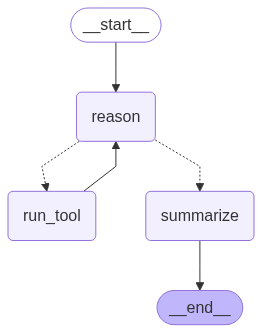

In [10]:
# Nodes
builder = StateGraph(State)
builder.add_node("reason", reason_and_select_tool)
builder.add_node("run_tool", ToolNode(tools=tools))
builder.add_node("summarize", summarize_final)

# Edges
builder.add_edge(START, "reason")
builder.add_conditional_edges(
    "reason", 
    should_continue, 
    {
        "run_tool": "run_tool", 
        "summarize": "summarize"
    }
)
builder.add_edge("run_tool", "reason")
builder.add_edge("summarize", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
query = (
    "What's the share price of Tesla and convert 1 shares to Indian Rupee? "
    "What's Apple's P/E ratio and how does it compare with Google? "
    "If I invest 100000 INR in Tesla for 4 years at 7% annual return, what will I have?"
)
response = graph.invoke({
    "messages": [HumanMessage(content=query)]
})
from pprint import pprint
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What's the share price of Tesla and convert 1 shares to Indian Rupee? What's Apple's P/E ratio and how does it compare with Google? If I invest 100000 INR in Tesla for 4 years at 7% annual return, what will I have?
================================== Ai Message ==================================
Tool Calls:
  google_finance (call_k0ofmYDcGVf5mImtAEBc7ZMv)
 Call ID: call_k0ofmYDcGVf5mImtAEBc7ZMv
  Args:
    query: Tesla share price
  get_alpha_vantage_tool (call_WCayMp3fjILPcMxS9oJI7WB4)
 Call ID: call_WCayMp3fjILPcMxS9oJI7WB4
  Args:
    from_currency: USD
    to_currency: INR
  google_finance (call_8OPPw3cboltQgsqNfeD1osxE)
 Call ID: call_8OPPw3cboltQgsqNfeD1osxE
  Args:
    query: Apple PE ratio
  google_finance (call_PYJoBAf1qMKZM0jreMQKVReq)
 Call ID: call_PYJoBAf1qMKZM0jreMQKVReq
  Args:
    query: Google PE ratio
================================= Tool Message =================================
Name: g